<a href="https://colab.research.google.com/github/mehmedbilgin/music_recommendation_system/blob/main/music_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Fatih Mehmed Bilgin - Emir Muhammet Aydemir - Kadir Kartal / Yapay Zekaya Giriş Projesi: Müzik Öneri Sistemi  
#!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from IPython.display import Image, display

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 2.7 MB/s eta 0:00:00


In [3]:
# Spotify API anahtarlarınızı buraya ekleyin
client_id = 'bc6f5a71013f4155a0874aebe0100635'
client_secret = '98a1134230354a64ac77120d3572a6bb'

# API kimlik doğrulaması
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [5]:
# Veri setini oluşturma
playlist_id2 = input("Lütfen Spotify çalma listesi ID'nizi girin: ")
playlist_id = playlist_id2  #'1Bup6VFGQf3NiuYt77MfKO' # Örnek bir çalma listesi ID'si
playlist = sp.playlist(playlist_id)
tracks = playlist["tracks"]["items"]
ids = []
names = []
artists = []
images = []
for track in tracks:
    ids.append(track["track"]["id"])
    names.append(track["track"]["name"])
    artist = track["track"]["artists"][0]["name"]
    artists.append(artist)
    image = track["track"]["album"]["images"][0]["url"]
    images.append(image)
features = []
for i in range(0,len(ids),50):
    audio_features = sp.audio_features(ids[i:i+50])
    for track in audio_features:
        features.append(track)
df = pd.DataFrame(features)
df["name"] = names
df["artist"] = artists
df["image"] = images
df = df.drop(['analysis_url', 'track_href', 'type', 'uri', 'id'], axis=1)
df = df[['name', 'artist', 'image', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
df.to_csv('spotify_data.csv', index=False)

Lütfen Spotify çalma listesi ID'nizi girin: 1Bup6VFGQf3NiuYt77MfKO


In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
print() # boş bir satır ekleme
# Veri setini yükleme
df = pd.read_csv('spotify_data.csv')
print('Veri setindeki toplam şarkı sayısı:', len(df))
# Özellikleri ölçeklendirme
scaler = StandardScaler()
X = df.drop(['name', 'artist', 'image'], axis=1)
X = scaler.fit_transform(X)
print() # boş bir satır ekleme
# Modeli oluşturma
model = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
model.fit(X)


Veri setindeki toplam şarkı sayısı: 100



NearestNeighbors(algorithm='ball_tree', n_neighbors=10)

In [7]:
# Örnek bir şarkı seçme
query_index = 2
query = X[query_index].reshape(1,-1)

In [8]:
# En yakın şarkıları bulma
distances, indices = model.kneighbors(query)

In [9]:
# Öneri listesi oluşturma
recommendations = []
for i in indices[0]:
    song = df.iloc[i]
    recommendations.append((song['name'], song['artist'], song['image']))
#print(recommendations)

In [10]:
# Öneri listesini daha görsel hale getirme
from PIL import Image
import requests
from io import BytesIO

recommendations_with_images = []
for i, rec in enumerate(recommendations):
    # Şarkının kapak resmini alıp, öneri listesine ekleyin
    track_name = df.iloc[indices[0][i]]['name']
    track_artist = df.iloc[indices[0][i]]['artist']
    results = sp.search(q=track_name + ' ' + track_artist, type='track', limit=1)
    image_url = results['tracks']['items'][0]['album']['images'][2]['url'] # 300x300 boyutunda olan resmi alıyoruz
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    recommendations_with_images.append((rec, img))

Öneri Listesi:
1. ('I Wanna Be Yours', 'Arctic Monkeys', 'https://i.scdn.co/image/ab67616d0000b2734ae1c4c5c45aabe565499163')


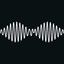


2. ('HIGHEST IN THE ROOM', 'Travis Scott', 'https://i.scdn.co/image/ab67616d0000b273e42b5fea4ac4c3d6328b622b')


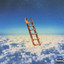


3. ('pushin P (feat. Young Thug)', 'Gunna', 'https://i.scdn.co/image/ab67616d0000b27314d91ebdd6d7e2931322cc1a')


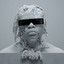


4. ('Got It On Me', 'Pop Smoke', 'https://i.scdn.co/image/ab67616d0000b27377ada0863603903f57b34369')


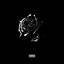


5. ('WORTH NOTHING (feat. Oliver Tree) - Fast & Furious: Drift Tape/Phonk Vol 1', 'TWISTED', 'https://i.scdn.co/image/ab67616d0000b27333c32473dad69f1e6834c904')


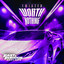


6. ('Circo Loco', 'Drake', 'https://i.scdn.co/image/ab67616d0000b27302854a7060fccc1a66a4b5ad')


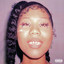


7. ('Bad Memories (feat. Elley Duhé & FAST BOY)', 'MEDUZA', 'https://i.scdn.co/image/ab67616d0000b27320abd13bf81d8ee406827c38')


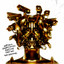


8. ("i'm yours", 'Isabel LaRosa', 'https://i.scdn.co/image/ab67616d0000b2737f73e6587c8ced7cad6e1e02')


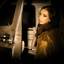


9. ('Escapism. - Sped Up', 'RAYE', 'https://i.scdn.co/image/ab67616d0000b27357dd31ec4e9dbc7f4238f69a')


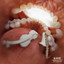


10. ('Pink Venom', 'BLACKPINK', 'https://i.scdn.co/image/ab67616d0000b273580ac3ad7dfc81e509171120')


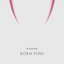

In [11]:
# Öneri listesini gösterme
print("Öneri Listesi:")
for i, rec in enumerate(recommendations_with_images):
    print(str(i+1) + ".", rec[0])
    display(rec[1])
    print()